In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.utils import to_networkx
from torch_geometric.nn.models import Node2Vec
import numpy as np

In [2]:
def create_cycle_graph(n_nodes):
    edge_index = [[i, (i + 1) % n_nodes] for i in range(n_nodes)] + [
        [(i + 1) % n_nodes, i] for i in range(n_nodes)
    ]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([0]),
        num_nodes=n_nodes,
    )


def create_complete_graph(n_nodes):
    edge_index = [[i, j] for i in range(n_nodes) for j in range(n_nodes) if i != j]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([1]),
        num_nodes=n_nodes,
    )


def create_line_graph(n_nodes):
    edge_index = [[i, i + 1] for i in range(n_nodes - 1)] + [
        [i + 1, i] for i in range(n_nodes - 1)
    ]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([2]),
        num_nodes=n_nodes,
    )


def create_star_graph(n_leaves):
    edge_index = [[0, i] for i in range(1, n_leaves + 1)] + [
        [i, 0] for i in range(1, n_leaves + 1)
    ]
    return Data(
        edge_index=torch.tensor(edge_index).t().contiguous(),
        y=torch.tensor([3]),
        num_nodes=n_leaves + 1,
    )


def create_wheel_graph(n_nodes):
    edges = []
    for i in range(1, n_nodes):
        edges.append([0, i])
        edges.append([i, i % (n_nodes - 1) + 1])
    edges += [[j, i] for i, j in edges]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return Data(edge_index=edge_index, y=torch.tensor([4]), num_nodes=n_nodes)

In [3]:
def plot_graph(data):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(5, 5))
    nx.draw(
        G,
        with_labels=False,
        node_color="skyblue",
        node_size=500,
        edge_color="k",
        linewidths=2,
        font_size=15,
        pos=nx.spring_layout(G),
    )
    plt.show()

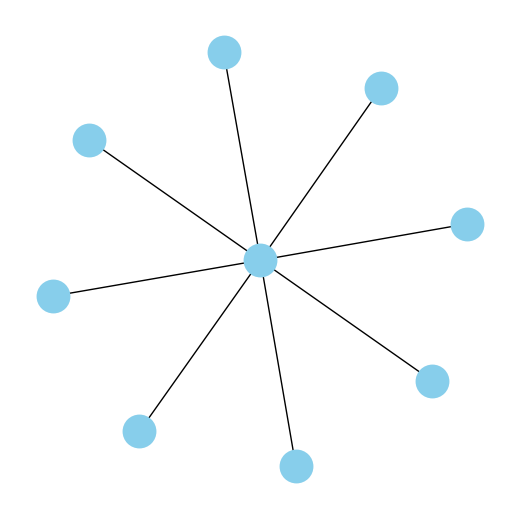

In [4]:
data = create_star_graph(8)
plot_graph(data)

In [5]:
model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=True,
)

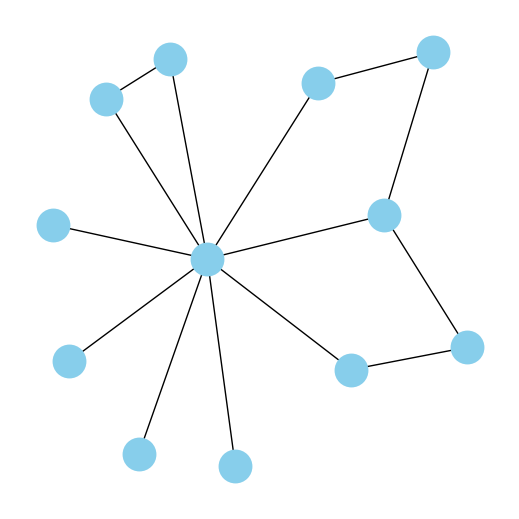

In [6]:
def add_noise_to_graph(graph, num_new_nodes, avg_new_edges_per_node=2):
    assert avg_new_edges_per_node > 0, "Each new node should have at least one edge."

    num_nodes = graph.num_nodes
    num_edges = graph.edge_index.size(1)

    new_edges_list = []
    for new_node_id in range(num_nodes, num_nodes + num_new_nodes):
        connections = np.random.choice(num_nodes, avg_new_edges_per_node, replace=False)
        for conn in connections:
            new_edges_list.append([new_node_id, conn])
            new_edges_list.append([conn, new_node_id])

    new_edges = torch.tensor(new_edges_list, dtype=torch.long).t()
    new_edge_index = torch.cat([graph.edge_index, new_edges], dim=1)

    if graph.x is not None:
        new_node_features = torch.zeros(num_new_nodes, graph.x.size(1))
        new_x = torch.cat([graph.x, new_node_features], dim=0)
    else:
        new_x = None

    new_graph = Data(
        x=new_x, edge_index=new_edge_index, num_nodes=graph.num_nodes + num_new_nodes
    )

    return new_graph


new_graph = add_noise_to_graph(data, 3, 2)
plot_graph(new_graph)

In [7]:
funcs = [
    create_complete_graph,
    create_cycle_graph,
    create_line_graph,
    create_star_graph,
    create_wheel_graph,
]

nodes = [2, 3, 4]
edges = [4, 5, 6]


def create_dataset():
    graphs = []
    for func in funcs:
        graph = func(8)
        for _ in range(4):
            for n in nodes:
                for e in edges:
                    noisy_graph = add_noise_to_graph(graph, n, e)
                    graphs.append(noisy_graph)
    return graphs


graphs = create_dataset()

In [8]:
class GraphDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]

180


In [9]:
import torch
from torch_geometric.nn import Node2Vec


def add_node2vec_features(
    data_list,
    embedding_dim=32,
    walk_length=10,
    context_size=5,
    walks_per_node=20,
    num_negative_samples=2,
    batch_size=128,
    learning_rate=0.01,
    epochs=200,
):
    updated_data_list = []
    for data in data_list:
        if "edge_index" not in data:
            print("Graph does not contain edge_index.")
            continue

        model = Node2Vec(
            data.edge_index,
            embedding_dim=embedding_dim,
            walk_length=walk_length,
            context_size=context_size,
            walks_per_node=walks_per_node,
            num_negative_samples=num_negative_samples,
            sparse=True,
        )

        loader = model.loader(batch_size=batch_size, shuffle=True, num_workers=0)
        optimizer = torch.optim.SparseAdam(model.parameters(), lr=learning_rate)

        model.train()
        for epoch in range(epochs):
            total_loss = 0
            for pos_rw, neg_rw in loader:
                optimizer.zero_grad()
                loss = model.loss(pos_rw, neg_rw)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f"Epoch: {epoch}, Loss: {total_loss / len(loader)}")

        model.eval()
        with torch.no_grad():
            embeddings = model()

        data.x = (
            torch.cat([data.x, embeddings], dim=1) if data.x is not None else embeddings
        )

        updated_data_list.append(data)

    return updated_data_list

In [10]:
updated_graphs = add_node2vec_features(graphs)

Epoch: 0, Loss: 7.478234767913818
Epoch: 1, Loss: 7.426182746887207
Epoch: 2, Loss: 7.155195236206055
Epoch: 3, Loss: 7.238770484924316
Epoch: 4, Loss: 7.085177421569824
Epoch: 5, Loss: 6.761147499084473
Epoch: 6, Loss: 6.661709785461426
Epoch: 7, Loss: 6.532708644866943
Epoch: 8, Loss: 6.659286022186279
Epoch: 9, Loss: 6.303476810455322
Epoch: 10, Loss: 6.331547737121582
Epoch: 11, Loss: 5.920251846313477
Epoch: 12, Loss: 5.884708881378174
Epoch: 13, Loss: 6.019604206085205
Epoch: 14, Loss: 5.757540702819824
Epoch: 15, Loss: 5.485043048858643
Epoch: 16, Loss: 5.544253826141357
Epoch: 17, Loss: 5.713720321655273
Epoch: 18, Loss: 5.334418773651123
Epoch: 19, Loss: 5.410079479217529
Epoch: 20, Loss: 5.354331016540527
Epoch: 21, Loss: 5.211167812347412
Epoch: 22, Loss: 5.1748247146606445
Epoch: 23, Loss: 5.045273780822754
Epoch: 24, Loss: 4.877236366271973
Epoch: 25, Loss: 4.947243690490723
Epoch: 26, Loss: 4.98832368850708
Epoch: 27, Loss: 4.743826866149902
Epoch: 28, Loss: 4.97031354904